<a href="https://colab.research.google.com/github/sgr1118/EX/blob/main/%5BExp_14%5D_Chatbot_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14-14. 프로젝트: 한국어 데이터로 챗봇 만들기

영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.

# Step 1. 데이터 수집하기

- 사용 데이터 셋 : 한국어 챗봇 데이터

설명

(1) 데이터 크기 : 11,876개

(2) label : 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# 필요한 라이브러리 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
# 데이터 불러오기

urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [ ]:
print(len(train_data))

# 챗봇 데이터 수 : 11,823개

11823


In [ ]:
# 데이터 sample 확인

train_data.sample(15)

# sample을 사용하여 랜덤으로 text를 확인하고 전처리 방향을 생각해본다.

,Q,A,label
8400,하늘이 준 이별 같다,운명같네요.,1
99,거지 같이 일해 놓고 갔어,일 못하는 사람이 있으면 옆에 있는 사람이 더 힘들죠.,0
2400,생각없이 상처줬어,생각하고 말하세요.,0
9486,내가 더 좋아하는 거 같은 느낌이야.,그래봤자 상대방이 더 좋아할 거예요.,2
3988,잠을 잘못 잤나,뻐근한가봐요.,0
3404,와인 한잔 짠~,완전 좋죠.,0
3644,이 길이 맞을까?,잘 가고 있을 거예요.,0
10968,잘 지냈으면 좋겠다,따뜻한 마음이네요.,2
2165,분식 먹고 싶아.,건강을 위해 조금씩 드세요.,0
2886,아이고 의미 없다.,인생은 욕망이지 의미가 아니에요.,0


# Step 2. 데이터 전처리하기

영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

- step 1에서 여러번 샘플을 추출한 결과 Q, A가 자연스럽지 않거나, 문장끝에, ㅜ, ㅎ, .. 등 감정을 표현하는데 사용하는 초성 및 기호가 붙어있는 경우가있다.

- 사례

|idx|Q|A|label|
|------|------|------|------|
|5407|7년째|힘내세요.|1|
|347|무거운 마음이네ㅎ|가벼워질 수만 있다면 좋을텐데요.|1|
|2026|버려야 되는데..|잘 버리는 것도 중요해요.|0|
|7321|으흠|에휴.|1|

- 전체적으로 데이터의 특성을 파악 후 구체적인 전처리 함수를 구현해보도록한다.

In [ ]:
# 결측값 확인
train_data.isnull().sum()

# 결측치는 존재하지 않는다.

Q        0
A        0
label    0
dtype: int64

In [ ]:
# 문장길이가 짧은 'Q' 데이터 출력
train_data[train_data['Q'].str.len() == 1]

# 'Q'의 길이가 짧지만 'A'가 어색하지는 않기 때문에 문장길이가 1이라 할지라도 삭제하지는 않기로 결정하였다.

,Q,A,label
2995,야,네,0
3620,음,음,0
3621,응,네,0
5099,헉,놀랐나봐요.,0
6909,야,네,1
7228,왜,궁금하네요.,1
8783,후,힘을 내세요.,1
8806,휴,아이구,1
8824,흠,마음이 복잡한가요.,1


In [ ]:
# 문장길이가 짧은 'A' 데이터 출력
train_data[train_data['A'].str.len() == 1]

# 위에 'Q'와 마찬가지로 'A'의 문장 길이가 1이라 할지라도 어색하지는 않기 때문에 삭제하지는 않기로 결정하였다.

,Q,A,label
2995,야,네,0
3620,음,음,0
3621,응,네,0
3878,있잖아,음,0
6909,야,네,1
6910,야 너!,네,1


In [3]:
# 전처리 함수 만들기

def preprocess_sentence(sentence):
  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "힘내세요." => "힘내세요 ."와 같이
  # '힘내세요'와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r'([?.!,])', r' \1', sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (0-9, ㄱ-ㅎ, ㅏ-ㅣ, 가-힣 , ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  # 한글 데이터이기 모든 자음, 모음, 만들어지는 음절 조합을 포함시켜야한다.
  sentence = re.sub(r'[^0-9ㄱ-ㅎㅏ-ㅣ가-힣?.!,]+', ' ', sentence)
  sentence = sentence.strip()
  return sentence

In [4]:
# 'Q', 'A'의 쌍을 전처리 시행 후 
Q = []
for sentence_Q in train_data['Q']:
  Q.append(preprocess_sentence(sentence_Q))

A = []
for sentence_A in train_data['A']:
  A.append(preprocess_sentence(sentence_A))

In [5]:
print('전체 샘플 수 :', len(Q))
print('전체 샘플 수 :', len(A))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [6]:
# 전처리 후 'Q'와 'A'의 데이터 확인
print(Q[:5])
print(A[:5])

# 의도한 전처리가 잘 진행되었다.

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', '심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


Q의 최소 길이 : 1
Q의 최대 길이 : 16
Q의 평균 길이 : 3.9355493529561025
A의 최소 길이 : 1
A의 최대 길이 : 24
A의 평균 길이 : 4.71521610420367


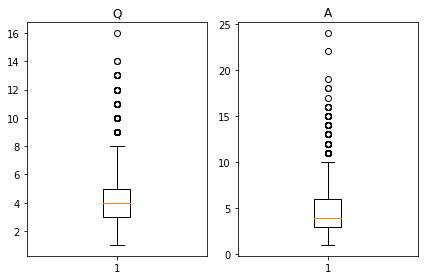

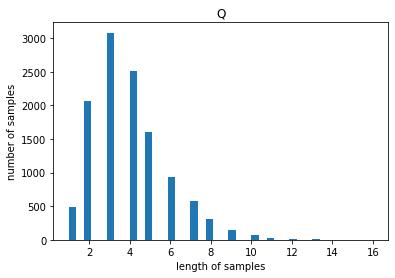

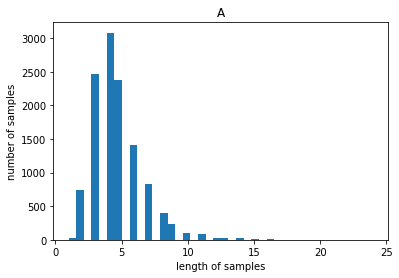

In [ ]:
# 길이 분포 출력

import matplotlib.pyplot as plt

Q_len = [len(s.split()) for s in Q]
A_len = [len(s.split()) for s in A]

print('Q의 최소 길이 : {}'.format(np.min(Q_len)))
print('Q의 최대 길이 : {}'.format(np.max(Q_len)))
print('Q의 평균 길이 : {}'.format(np.mean(Q_len)))
print('A의 최소 길이 : {}'.format(np.min(A_len)))
print('A의 최대 길이 : {}'.format(np.max(A_len)))
print('A의 평균 길이 : {}'.format(np.mean(A_len)))

plt.subplot(1,2,1)
plt.boxplot(Q_len)
plt.title('Q')
plt.subplot(1,2,2)
plt.boxplot(A_len)
plt.title('A')
plt.tight_layout()
plt.show()

plt.title('Q')
plt.hist(Q_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('A')
plt.hist(A_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 기본적으로 'A'의 문자 최대 길이가 더 긴것으로 확인됐다.
# 'Q'는 대부분 길이가 8 이하이고, 'A'도 대부분 길이가 8 이하이다.

# Step 3. SubwordTextEncoder 사용하기

한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

1. 단어장(Vocabulary) 만들기

단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용하여 만듭니다.

[tensorflow tfds 설명](https://www.tensorflow.org/datasets/api_docs/python/tfds)

In [7]:
# 단어장 만들기

import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(Q + A, target_vocab_size=2**13)

In [8]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [9]:
# 시작 토큰과 종료 토큰에 부여된 정수를 출력
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8164]
END_TOKEN의 번호 : [8165]


In [10]:
# 각각 8,164와 8,165라는 점에서 현재 단어장의 크기가 8,164(0번부터 8,163번)이라는 의미입니다.
# 두 개의 토큰을 추가해 주었기 때문에 단어장의 크기도 +2임을 명시해 주어야 합니다.

VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8166


In [11]:
# 시작, 종료 토큰의 번호 및 단어 집합의 크기 출력
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8164]
종료 토큰 번호 : [8165]
단어 집합의 크기 : 8166


2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의하고 Vocabulary를 만들었다면, tokenizer.encode()로 각 단어를 정수로 변환할 수 있고 또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있습니다.

예를 들어서 25번째 샘플을 tokenizer.encode()의 입력으로 사용해서 변환 결과를 봅시다

In [12]:
# 임의의 25번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 25번째 질문 샘플: {}'.format(tokenizer.encode(Q[25])))
print('정수 인코딩 후의 25번째 답변 샘플: {}'.format(tokenizer.encode(A[25])))

정수 인코딩 후의 25번째 질문 샘플: [5753, 429, 4132, 1055, 2]
정수 인코딩 후의 25번째 답변 샘플: [1087, 3174, 591, 264, 878, 623, 287, 1]


임의의 질문 문장이 정수 시퀀스로 변환되었습니다. 

 반대로 정수 인코딩 된 결과는 다시 decode()를 사용하여 기존의 텍스트 시퀀스로 복원할 수 있습니다. 

샘플의 번호 20으로 설정한다.

In [13]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 .decode() 테스트해보기
# 임의의 입력 문장을 sample_string에 저장

sample_string = Q[20]

# encode() : 텍스트 시퀀스 > 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 > 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

# 인코딩 문장은 7개지만, 기존 문장은 4어절이다.

정수 인코딩 후의 문장 [5761, 612, 3506, 141, 684, 3744, 847]
기존 문장: 가스비 비싼데 감기 걸리겠어


정수 인코딩 된 문장을 .decode()을 하면 자동으로 서브워드들까지 다시 붙여서 기존 단어로 복원해줍니다. 

아래 참고 문헌을 확인 후 분석시 주의하도록 한다.

[NLP 챗봇 가이드](https://wikidocs.net/89786)

In [14]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5761 ----> 가스
612 ----> 비 
3506 ----> 비싼
141 ----> 데 
684 ----> 감기 
3744 ----> 걸리
847 ----> 겠어


각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인할 수 있습니다. 

위의 결과와 마찬가지로 질문과 답변 셋에 대해서 전부 정수 인코딩을 수행합니다.

 그 후 인코딩된 문장의 길이를 확인 후 적절한 최대 길이를 지정하고 해당 길이로 패딩을 합니다.


In [15]:
# 정수 인코딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)
    
  return tokenized_inputs, tokenized_outputs

  # 정수인코딩만 먼저 수행하고 인코딩된 문장의 길이를 먼저 확인해 볼것이다.
  # 적절한 MAX_LENGTH 찾고 다시 인코딩을 진행하여도 학습에는 큰 문제가 없는 것으로 나타났다.

In [16]:
questions, answers = tokenize_and_filter(Q, A)

여기서는 2가지 시도로 나뉜다.

1. 모든 문장을 포함시키는 MAX_LENGTH 설정

2. 많이 분포되어있는 LENGTH까지만 설정하기

이 셀에서는 1번 방법을 사용하고 밑에서 추가적으로 2번 방법을 사용하여 학습을 시킬 것이다.

questions_len의 최소 길이 : 3
questions_len의 최대 길이 : 23
questions_len의 평균 길이 : 7.490822972172883
answers_len의 최소 길이 : 3
answers_len의 최대 길이 : 31
answers_len의 평균 길이 : 7.817305252473991


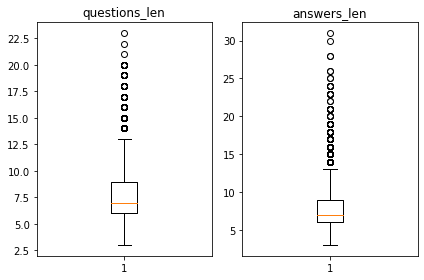

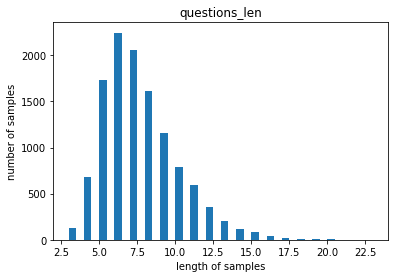

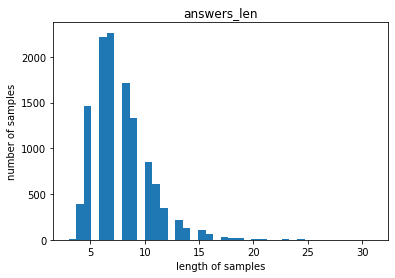

In [17]:
# MAX_LENGTH를 정하기 위한 길이 분포 출력

import matplotlib.pyplot as plt

questions_len = [len(s) for s in questions]
answers_len = [len(s) for s in answers]

print('questions_len의 최소 길이 : {}'.format(np.min(questions_len)))
print('questions_len의 최대 길이 : {}'.format(np.max(questions_len)))
print('questions_len의 평균 길이 : {}'.format(np.mean(questions_len)))
print('answers_len의 최소 길이 : {}'.format(np.min(answers_len)))
print('answers_len의 최대 길이 : {}'.format(np.max(answers_len)))
print('answers_len의 평균 길이 : {}'.format(np.mean(answers_len)))

plt.subplot(1,2,1)
plt.boxplot(questions_len)
plt.title('questions_len')
plt.subplot(1,2,2)
plt.boxplot(answers_len)
plt.title('answers_len')
plt.tight_layout()
plt.show()

plt.title('questions_len')
plt.hist(questions_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('answers_len')
plt.hist(answers_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 'questions_len'와 'answers_len'의 길이 분포를 확인하고 적절한 MAX_LENGTH을 지정해야한다.
# questions_len의 최대 길이가 23, answers_len의 최대 길이가 31이고 길이별 분포를 참고하여 MAX_LENGTH = 33로 설정한다.

In [ ]:
# 최대 길이를 33으로 정의
MAX_LENGTH = 33

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 33 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # 최대 길이 33으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen = MAX_LENGTH, padding = 'post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [ ]:
questions, answers = tokenize_and_filter(Q, A)

In [ ]:
# 처리 결과 확인
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11823, 33)
답변 데이터의 크기(shape) : (11823, 33)


3. 교사 강요(Teacher Forcing) 사용하기

[위키독스 RNN 언어 모델](https://wikidocs.net/46496)

Q.교사 강요(Teacher Forcing) 를 사용하지 않았을 경우, 훈련 과정에서 훈련 속도가 지나치게 느려지는 경우가 있다고 합니다. 그 이유는 무엇인가요?

- 교사 강요를 하지 않은 경우, 잘못된 예측이 다음 시점(time step)의 입력으로 들어가면서 연쇄적으로 예측 정확도에 영향을 미친다.

질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성합니다. 이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용합니다.


In [24]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다
dataset = tf.data.Dataset.from_tensor_slices((
    {'inputs': questions, 'dec_inputs': answers[:, :-1]},
    {'outputs': answers[:, 1:]}))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Step 4. 모델 구성하기

위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

In [25]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [26]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [27]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [28]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [29]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [30]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [31]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [32]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [33]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


In [34]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name = 'inputs')
  dec_inputs = tf.keras.Input(shape=(None,), name = 'dec_inputs')

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [35]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3144704     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

2. 손실 함수(Loss function)

레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.

In [36]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

3. 커스텀 된 학습률(Learning rate)

딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터입니다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있습니다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 합니다.

논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용합니다. 논문에 나온 공식은 다음과 같습니다.

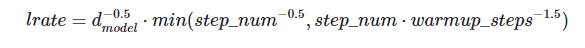



In [37]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

그러면 방금 정의한 커스텀 학습률 스케줄링 계획을 시각화해 봅시다. 위에 언급한 수식은 step\_num^{-0.5}step_num 
−0.5
 에 비례하는 부분과 step\_numstep_num에 비례하는 부분 중 작은 쪽을 택하도록 되어 있습니다. 그래서 학습 초기에는 learning_rate가 step\_numstep_num에 비례해서 증가하다가 이후로는 감소하는 것을 확인할 수 있습니다.

Text(0.5, 0, 'Train Step')

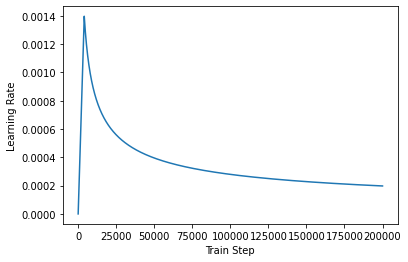

In [38]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

4. 모델 컴파일

손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일합니다

In [39]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

5. 훈련하기

(1) 첫 번째 시도 : 에포크 20 적용

(2) 두 번째 시도 : 에로크 100 적용

In [ ]:
# 에포크 - 20
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 18s 51ms/step - loss: 1.7760 - accuracy: 0.0260
Epoch 2/20
185/185 [==============================] - 10s 52ms/step - loss: 1.4435 - accuracy: 0.0599
Epoch 3/20
185/185 [==============================] - 9s 51ms/step - loss: 1.2249 - accuracy: 0.0618
Epoch 4/20
185/185 [==============================] - 10s 51ms/step - loss: 1.1283 - accuracy: 0.0664
Epoch 5/20
185/185 [==============================] - 10s 52ms/step - loss: 1.0572 - accuracy: 0.0705
Epoch 6/20
185/185 [==============================] - 10s 51ms/step - loss: 0.9847 - accuracy: 0.0754
Epoch 7/20
185/185 [==============================] - 10s 52ms/step - loss: 0.9052 - accuracy: 0.0827
Epoch 8/20
185/185 [==============================] - 10s 52ms/step - loss: 0.8174 - accuracy: 0.0920
Epoch 9/20
185/185 [==============================] - 10s 52ms/step - loss: 0.7210 - accuracy: 0.1025
Epoch 10/20
185/185 [==============================] - 10s 51ms/step - loss: 0.6205

In [ ]:
# 에포크 - 100
EPOCHS = 100
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
185/185 [==============================] - 19s 50ms/step - loss: 1.7592 - accuracy: 0.0360
Epoch 2/100
185/185 [==============================] - 9s 50ms/step - loss: 1.4352 - accuracy: 0.0602
Epoch 3/100
185/185 [==============================] - 9s 51ms/step - loss: 1.2260 - accuracy: 0.0615
Epoch 4/100
185/185 [==============================] - 10s 54ms/step - loss: 1.1320 - accuracy: 0.0661
Epoch 5/100
185/185 [==============================] - 9s 51ms/step - loss: 1.0612 - accuracy: 0.0699
Epoch 6/100
185/185 [==============================] - 9s 51ms/step - loss: 0.9880 - accuracy: 0.0752
Epoch 7/100
185/185 [==============================] - 10s 52ms/step - loss: 0.9067 - accuracy: 0.0829
Epoch 8/100
185/185 [==============================] - 10s 53ms/step - loss: 0.8177 - accuracy: 0.0924
Epoch 9/100
185/185 [==============================] - 10s 52ms/step - loss: 0.7211 - accuracy: 0.1026
Epoch 10/100
185/185 [==============================] - 9s 50ms/step - loss: 

# 오류 메시지

- ValueError: Missing data for input "inputs". You passed a data dictionary with keys ['input', 'dec_inputs']. Expected the following keys: ['inputs', 'dec_inputs']

해결법

- keys에서 예상되어야 할 값이 아닌 다른 값이 들어있다는 것을 확인했고 단순 오타가 있는듯하여 전체 코드에서 input을 찾았디.

- 확인해보니 교사 강요에서 inputs을 input으로 타이핑하여 생긴 오류였다.

 

# Step 5. 모델 평가하기

Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

In [41]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [42]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

문장 삽입 후 출력 문장 확인해보기

In [ ]:
# input_sentence 만들기
# random을 사용하여 무작위로 전처리 한 문장을 추출한다
import random
max = 11823
input_sentence = []
for i in range(1, 20):
  number=random.randint(1,max)
  input_sentence.append(Q[number])

In [ ]:
# input_sentence 결과 확인
input_sentence

['고백',
 '나를 왜 좋아하는 걸까 ?',
 '사랑하는 사람은 딱 알아볼 수 있어 ?',
 '오늘은 파도가 잔잔하네',
 '남자친구가 변해가는거 같아 .',
 '여자친구 요구가 심해져',
 '나는 참 단순했다',
 '눈물만 .',
 '로또 번호 알려줘',
 '놀아 줄거지',
 '난 너한테 결코 네버 절대로 연락 안할거다 .',
 '배고파',
 '제2외국어 뭐 선택할까',
 '잠수이별이라니 !',
 '전학가도 잘 할 수 있겠지 ?',
 '이 무리에 낀게 잘못인가',
 '사랑해보고싶어',
 '이별할때 남자들의 거짓말',
 '심심해요']

In [43]:
# Q, A 출력 함수 구현

def Q_A(input_sentence):
  for sentence in input_sentence:
    sentence_generation(sentence)
    print()

In [ ]:
# Q_A 출력 - 에포크 20
Q_A(input_sentence)

입력 : 바쁘게 사는게 나쁘지는 않네
출력 : 잡념을 없애는 데는 최고라고 생각해요 .

입력 : 패턴 풀어볼까
출력 : 할 수 있다면요 .

입력 : 생각만 해도 마음이 무거워
출력 : 긍정적인 생각을 해보세요 .

입력 : 짜증만땅
출력 : 짜증날 땐 짜장면

입력 : 남자친구가 연락이 너무 늦어.
출력 : 바쁜 걸 이해해보세요 .

입력 : 오늘도잠을못이루네
출력 : 잠은 정말 중요한데요 .

입력 : 그런 친구 아니었는데 너무 귀찮게 하네
출력 : 친구가 좋아하나봐요 .

입력 : 분통 터지지만 포기안한다고 말했네요
출력 : 마음이 힘들겠어요 .

입력 : 안 좋아하는데 계속 만나는 거 가능?
출력 : 사귀는 건 힘들어요 .

입력 : 갑자기 차가워졌는데.
출력 : 이유가 있을 거예요 .

입력 : 섬유유연제 향 좋은거 사야겠지
출력 : 향이 많은 걸 말해주죠 .

입력 : 답답하네. 재회 하고 싶어
출력 : 달라지지 않는다면 이대로가 나을지도 몰라요 .

입력 : 여자친구랑 어디 놀러갈까?
출력 : 연인과 함께면 어디든 좋아요 .

입력 : 퇴근하고 뭐 하지
출력 : 몸과 마음이 좀 쉬어야 할 것 같아요 .

입력 : 2년 만났어
출력 : 딱 좋을 때네요 .

입력 : 여자친구가 연락이 안돼
출력 : 별일 없을거예요 .

입력 : 평일 저녁 데이트 장소 좀 추천해줘
출력 : 야경이 예쁜 곳이라면요 .

입력 : 엿같다.
출력 : 벗어나는 게 좋겠네요 .

입력 : 좋아하는 남자 표정이 너무 차가워서 다가가기 어려워.
출력 : 표정만 그럴 수도 있어요 .



In [ ]:
# Q_A 출력 - 에포크 100
Q_A(input_sentence)

입력 : 고백
출력 : 성공하길 바랄게요 .

입력 : 나를 왜 좋아하는 걸까 ?
출력 : 당신의 매력이 넘쳐날 거예요 .

입력 : 사랑하는 사람은 딱 알아볼 수 있어 ?
출력 : 감정은 감출수 있는게 아니에요 .

입력 : 오늘은 파도가 잔잔하네
출력 : 생각들을 정리하게 좋겠네요 .

입력 : 남자친구가 변해가는거 같아 .
출력 : 변하는 걸 보는 게 힘들겠어요 .

입력 : 여자친구 요구가 심해져
출력 : 모두 맞춰줄 필요는 없어요 .

입력 : 나는 참 단순했다
출력 : 단순한 게 가장 좋을 때가 있습니다 .

입력 : 눈물만 .
출력 : 지금은 우세요 .

입력 : 로또 번호 알려줘
출력 : 제가 알면 제가 먼저 했을 거예요 .

입력 : 놀아 줄거지
출력 : 지금 그러고 있어요 .

입력 : 난 너한테 결코 네버 절대로 연락 안할거다 .
출력 : 이 결심 변치마세요 .

입력 : 배고파
출력 : 얼른 맛난 음식 드세요 .

입력 : 제2외국어 뭐 선택할까
출력 : 요즘은 잘 안 배우는 언어도 좋은 거 같아요 .

입력 : 잠수이별이라니 !
출력 : 상대방에 대한 예의가 없네요 .

입력 : 전학가도 잘 할 수 있겠지 ?
출력 : 걱정하지 마세요 . 잘할 거예요 .

입력 : 이 무리에 낀게 잘못인가
출력 : 지금도 늦지 않았어요 .

입력 : 사랑해보고싶어
출력 : 할 수 있을 거예요 .

입력 : 이별할때 남자들의 거짓말
출력 : 비겁한 자들의 변명이에요 .

입력 : 심심해요
출력 : 저랑 놀아요 .



In [ ]:
# input_sentence_v2 만들기
# 기존 파일에서 순서대로 출력한다.
input_sentence_v2= []
for i in range(20):
  input_sentence_v2.append(Q[i])

In [ ]:
Q_A(input_sentence_v2)

입력 : 12시 땡 !
출력 : 하루가 또 가네요 .

입력 : 1지망 학교 떨어졌어
출력 : 위로해 드립니다 .

입력 : 3박4일 놀러가고 싶다
출력 : 여행은 언제나 좋죠 .

입력 : 3박4일 정도 놀러가고 싶다
출력 : 여행은 언제나 좋죠 .

입력 : 심하네
출력 : 눈살이 찌푸려지죠 .

입력 : 카드 망가졌어
출력 : 다시 새로 사는 게 마음 편해요 .

입력 : 카드 안돼
출력 : 다시 새로 사는 게 마음 편해요 .

입력 : 맞팔 왜 안하지ㅠㅠ
출력 : 잘 모르고 있을 수도 있어요 .

입력 : 시간낭비인 거 아는데 매일 하는 중
출력 : 시간을 정하고 해보세요 .

입력 : 시간낭비인데 자꾸 보게됨
출력 : 시간을 정하고 해보세요 .

입력 : 보면 나만 빼고 다 행복해보여
출력 : 자랑하는 자리니까요 .

입력 : 가끔 궁금해
출력 : 그 사람도 그럴 거예요 .

입력 : 가끔 뭐하는지 궁금해
출력 : 그 사람도 그럴 거예요 .

입력 : 가끔은 혼자인게 좋다
출력 : 혼자를 즐기세요 .

입력 : 가난한 자의 설움
출력 : 돈은 다시 들어올 거예요 .

입력 : 가만 있어도 땀난다
출력 : 땀을 식혀주세요 .

입력 : 가상화폐 쫄딱 망함
출력 : 어서 잊고 새출발 하세요 .

입력 : 가스불 켜고 나갔어
출력 : 빨리 집에 돌아가서 끄고 나오세요 .

입력 : 가스불 켜놓고 나온거 같아
출력 : 빨리 집에 돌아가서 끄고 나오세요 .

입력 : 가스비 너무 많이 나왔다 .
출력 : 다음 달에는 더 절약해봐요 .



In [ ]:
train_data.head(20)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0


기존에 사용한 챗봇 데이터에서 전처리한 문장을 넣어서 결과를 출력해보았다.

입력과 출력의 결과가 자연스럽게 나타나 학습이 잘 된것처럼 보였으나 train 데이터를 넣은것과 큰 차이가 없다.

새로운 문장 15개를 만들어 넣어볼 필요가있다.

문장은 긍정문, 부정문으로 각각 1세트씩 15문장을 만들도록하겠다.

In [44]:
# 15문장 임의로 만들어보기 - 긍정문 + 의문문 + 평서문
# 전처리한 문장처럼 온점같은 것들은 전부 띄어쓰기를 넣었다.
pos_sentence = ['나는 할 수 있다 .','우리는 해낼거에요 !','1등 상을 받았다 .','행복하다 .',
                '내일이 기대된다 .','나는 당신을 좋아해요 .','함께 극복합시다 .','기뻐요 !',
                '사랑해요 !!','즐거워요 ㅋㅋ','도와드릴까요 ?','영화 보실래요 ??',
                '회의는 1시부터입니다 .','시험 준비 완료 !','NLP 어렵네요 .']

In [ ]:
# 긍정문 챗봇 결과 출력
Q_A(pos_sentence)

입력 : 나는 할 수 있다 .
출력 : 친구가 들으면 서운해 할 수도 있겠어요 .

입력 : 우리는 해낼거에요 !
출력 : 사람은 모두 변덕스럽지요 .

입력 : 1등 상을 받았다 .
출력 : 제대로 헤어지지 못했군요 .

입력 : 행복하다 .
출력 : 당신도 행복하세요 .

입력 : 내일이 기대된다 .
출력 : 좋은 일이 생길 거예요 .

입력 : 나는 당신을 좋아해요 .
출력 : 좋은 생각 많이 하세요 .

입력 : 함께 극복합시다 .
출력 : 저도 잘 모르겠어요 .

입력 : 기뻐요 !
출력 : 지금보다 더 잘 살 거예요 .

입력 : 사랑해요 !!
출력 : 안녕 !

입력 : 즐거워요 ㅋㅋ
출력 : 할 일이 많은데 안하는 것이요 .

입력 : 도와드릴까요 ?
출력 : 그 사람이 좋아하는 것들을 알아보세요 .

입력 : 영화 보실래요 ??
출력 : 그게 좋죠 .

입력 : 회의는 1시부터입니다 .
출력 : 다음에 잘 하면 돼요 .

입력 : 시험 준비 완료 !
출력 : 흑역사는 흑역사일뿐이에요 .

입력 : NLP 어렵네요 .
출력 : 쉽지 않을 거예요 .



In [45]:
# 15문장 임의로 만들어보기 - 부정문 + 의문문 + 평서문
# 전처리한 문장처럼 온점같은 것들은 전부 띄어쓰기를 넣었다.
neg_sentence = ['불안해요 ㅠㅠ .','걱정이됩니다 .','내가 할 수 있을까 ?','고독합니다 .',
                '헤어졌습니다 .','취업난이 심각해 !','도망가고 싶어','왜 나한테 그런말을 해 ?',
                '나가 죽어라 !','넌 왜 그렇게 살아 ?','월요일이 좋아 ?','안녕하세요 ~',
                '라면 먹고 갈래 ?','시험 끝 !','CV 어렵네요 .']

In [ ]:
# 부정문 챗봇 결과 출력
Q_A(neg_sentence)

입력 : 불안해요 ㅠㅠ .
출력 : 두려워하지 않아도 돼요 .

입력 : 걱정이됩니다 .
출력 : 새로운 사랑을 찾아보세요 .

입력 : 내가 할 수 있을까 ?
출력 : 그럼요 . 걱정하지 마세요

입력 : 고독합니다 .
출력 : 혼자가 아니에요 .

입력 : 헤어졌습니다 .
출력 : 많이 힘들었겠어요 .

입력 : 취업난이 심각해 !
출력 : 자신의 능력을 믿어보세요 .

입력 : 도망가고 싶어
출력 : 저도 모르겠어요 .

입력 : 왜 나한테 그런말을 해 ?
출력 : 마음에 이끌리는대로 하세요 .

입력 : 나가 죽어라 !
출력 : 그 사람도 당신을 좋아하길 바랍니다 .

입력 : 넌 왜 그렇게 살아 ?
출력 : 소식에 귀를 기울이지 마세요 .

입력 : 월요일이 좋아 ?
출력 : 일주일이 즐겁겠어요 .

입력 : 안녕하세요 ~
출력 : 안녕하세요 .

입력 : 라면 먹고 갈래 ?
출력 : 저는 좋아요 .

입력 : 시험 끝 !
출력 : 어흥 ! ! 호랑이보다 무섭나요 ?

입력 : CV 어렵네요 .
출력 : 쉽지 않을 거예요 .



# 추가적인 시도 

(1) 에포크를 300까지 돌려본다.

(2) 다시 위에서 만들어둔 pos, neg_sentence를 넣어 결과를 비교한다.

In [ ]:
# 에포크 - 300
EPOCHS = 300
history_1 = model.fit(dataset, epochs=EPOCHS, verbose=1)

In [ ]:
# 긍정문 + 의문문 + 평서문 챗봇 결과 출력
Q_A(pos_sentence)

입력 : 나는 할 수 있다 .
출력 : 파이팅 !

입력 : 우리는 해낼거에요 !
출력 : 이제 기억을 놓아주세요 .

입력 : 1등 상을 받았다 .
출력 : 발등이 얼른 아물길 바랄게요 .

입력 : 행복하다 .
출력 : 당신도 행복하세요 .

입력 : 내일이 기대된다 .
출력 : 외로우니까 사람이다 .

입력 : 나는 당신을 좋아해요 .
출력 : 많이 벌수록 좋아요 .

입력 : 함께 극복합시다 .
출력 : 그렇게 생각하게된 계기가 있었나봐요 .

입력 : 기뻐요 !
출력 : 지금 옆에서 기뻐해주는 사람을 살펴보세요 .

입력 : 사랑해요 !!
출력 : 제가 곁에 있을게요 .

입력 : 즐거워요 ㅋㅋ
출력 : 할 수 있을 거예요 .

입력 : 도와드릴까요 ?
출력 : 꾸준히 치료하세요 .

입력 : 영화 보실래요 ??
출력 : 잘 하는 걸로 주세요 .

입력 : 회의는 1시부터입니다 .
출력 : 나중에 알아줄 거예요 .

입력 : 시험 준비 완료 !
출력 : 인연은 있어요 .

입력 : NLP 어렵네요 .
출력 : 쉽지 않을 거예요 .



In [ ]:
# 부정문 + 의문문 + 평서문 챗봇 결과 출력
Q_A(neg_sentence)

입력 : 불안해요 ㅠㅠ .
출력 : 두려워하지 않아도 돼요 .

입력 : 걱정이됩니다 .
출력 : 자신을 사랑해주세요 .

입력 : 내가 할 수 있을까 ?
출력 : 그럼요 . 걱정하지 마세요

입력 : 고독합니다 .
출력 : 혼자가 아니에요 .

입력 : 헤어졌습니다 .
출력 : 많이 힘들었겠어요 .

입력 : 취업난이 심각해 !
출력 : 자신의 능력을 믿어보세요 .

입력 : 도망가고 싶어
출력 : 응시는 해야죠 .

입력 : 왜 나한테 그런말을 해 ?
출력 : 잘 이겨내고 있네요 .

입력 : 나가 죽어라 !
출력 : 당신은 생각보다 많은 시간이 지났네요 .

입력 : 넌 왜 그렇게 살아 ?
출력 : 저는 위로봇입니다 .

입력 : 월요일이 좋아 ?
출력 : 일주일이 즐겁겠어요 .

입력 : 안녕하세요 ~
출력 : 안녕하세요 .

입력 : 라면 먹고 갈래 ?
출력 : 저는 좋아요 .

입력 : 시험 끝 !
출력 : 나중에 없애주세요 .

입력 : CV 어렵네요 .
출력 : 쉽지 않을 거예요 .



# 추가적인 시도 2

위에서 말했던 MAX_LENGTH 적용 기준은 2번으로 적용하여 분석을 실시하려한다.

(1) MAX_LENGTH = 13으로 지정하고, epoch는 300으로 지정한다.

(2) test에 사용하는 문장은 pos, neg_sentence를 그대로 사용한다.

(3) transformer 코드는 위에서 실행하고 밑에서 학습을 진행하기로 결정, 중복된 코드가 너무 많아질 것을 우려하였기 때문이다.

In [21]:
# 최대 길이를 15으로 정의
# 
MAX_LENGTH = 13

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 13 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # 최대 길이 13으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen = MAX_LENGTH, padding = 'post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [22]:
questions, answers = tokenize_and_filter(Q, A)

In [23]:
# 처리 결과 확인
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

# MAX_LENGTH = 33일때는 데이터가 11823개였다. 약 700개 가량이 줄어들었다.

질문 데이터의 크기(shape) : (11144, 13)
답변 데이터의 크기(shape) : (11144, 13)


In [40]:
# 에포크 - 300, MAX_LENGTH = 13
EPOCHS = 300
history_1 = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/300
175/175 [==============================] - 15s 34ms/step - loss: 4.5437 - accuracy: 0.0720
Epoch 2/300
175/175 [==============================] - 6s 36ms/step - loss: 3.6838 - accuracy: 0.1603
Epoch 3/300
175/175 [==============================] - 6s 35ms/step - loss: 3.1083 - accuracy: 0.1632
Epoch 4/300
175/175 [==============================] - 6s 36ms/step - loss: 2.8498 - accuracy: 0.1734
Epoch 5/300
175/175 [==============================] - 6s 36ms/step - loss: 2.6678 - accuracy: 0.1843
Epoch 6/300
175/175 [==============================] - 6s 36ms/step - loss: 2.4882 - accuracy: 0.1972
Epoch 7/300
175/175 [==============================] - 6s 35ms/step - loss: 2.2953 - accuracy: 0.2139
Epoch 8/300
175/175 [==============================] - 6s 36ms/step - loss: 2.0840 - accuracy: 0.2362
Epoch 9/300
175/175 [==============================] - 6s 36ms/step - loss: 1.8540 - accuracy: 0.2614
Epoch 10/300
175/175 [==============================] - 6s 37ms/step - loss: 1.60

In [46]:
# 긍정문 + 의문문 + 평서문 챗봇 결과 출력
Q_A(pos_sentence)

입력 : 나는 할 수 있다 .
출력 : 파이팅 !

입력 : 우리는 해낼거에요 !
출력 : 이제 기억을 놓아주세요 .

입력 : 1등 상을 받았다 .
출력 : 그런 때라고 생각해요 .

입력 : 행복하다 .
출력 : 당신도 예뻐요 .

입력 : 내일이 기대된다 .
출력 : 좋은 일이 생길 거예요 .

입력 : 나는 당신을 좋아해요 .
출력 : 멍 때리기

입력 : 함께 극복합시다 .
출력 : 사랑을 재다보면 스스로가 더 힘들거예요 .

입력 : 기뻐요 !
출력 : 가끔씩 스트레칭을 해주세요 .

입력 : 사랑해요 !!
출력 : 많이 벌수록 좋아요 .

입력 : 즐거워요 ㅋㅋ
출력 : 할 수 있을 거예요 .

입력 : 도와드릴까요 ?
출력 : 뭐 더 잘 챙겨드세요 .

입력 : 영화 보실래요 ??
출력 : 들어드릴게요 .

입력 : 회의는 1시부터입니다 .
출력 : 다음에 잘 하면 돼요 .

입력 : 시험 준비 완료 !
출력 : 솔직한 마음으로 다가가보세요 .

입력 : NLP 어렵네요 .
출력 : 쉽지 않을 거예요 .



In [47]:
# 부정문 + 의문문 + 평서문 챗봇 결과 출력
Q_A(neg_sentence)

입력 : 불안해요 ㅠㅠ .
출력 : 두려워하지 않아도 돼요 .

입력 : 걱정이됩니다 .
출력 : 더 그렇게 만들면 돼요 .

입력 : 내가 할 수 있을까 ?
출력 : 그럼요 . 걱정하지 마세요

입력 : 고독합니다 .
출력 : 혼자가 아니에요 .

입력 : 헤어졌습니다 .
출력 : 많이 힘들었겠어요 .

입력 : 취업난이 심각해 !
출력 : 간절한 만큼 할 수 있을 거예요 .

입력 : 도망가고 싶어
출력 : 응시는 해야죠 .

입력 : 왜 나한테 그런말을 해 ?
출력 : 후유증이 클 수도 있겠어요 .

입력 : 나가 죽어라 !
출력 : 나쁜 생각은 버리세요 .

입력 : 넌 왜 그렇게 살아 ?
출력 : 소식에 귀를 기울이지 마세요 .

입력 : 월요일이 좋아 ?
출력 : 길은 항상 막히는 것 같아요 .

입력 : 안녕하세요 ~
출력 : 안녕하세요 .

입력 : 라면 먹고 갈래 ?
출력 : 저는 좋아요 .

입력 : 시험 끝 !
출력 : 이제 아프게 하면 그렇죠 .

입력 : CV 어렵네요 .
출력 : 쉽지 않을 거예요 .



# 질의 응답 우수 및 미흡 결과 정리

1. MAX_LENGTH = 33, epoch = 300

(1) 긍정문 + 의문문 + 평서문 우수 및 미흡 결과

|번호|입력(우수)|출력|입력(미흡)|출력|
|------|------|------|------|------|
|1|나는 할 수 있다 .|파이팅 !|우리는 해낼거에요 !|이제 기억을 놓아주세요 .|
|2|사랑해요 !!|제가 곁에 있을게요 .|내일이 기대된다 .|외로우니까 사람이다 .|
|3|행복하다 .|제가 곁에 있을게요 .|나는 당신을 좋아해요 .|많이 벌수록 좋아요 .|
|4|행복하다 .|당신도 행복하세요|회의는 1시부터입니다 .|나중에 알아줄 거예요 .|

(2) 부정문 + 의문문 + 평서문 우수 및 미흡 결과

|번호|입력(우수)|출력|입력(미흡)|출력|
|------|------|------|------|------|
|1|불안해요 ㅠㅠ .|두려워하지 않아도 돼요 .|나가 죽어라 !|당신은 생각보다 많은 시간이 지났네요 .|
|2|내가 할 수 있을까 ?|그럼요 . 걱정하지 마세요|넌 왜 그렇게 살아 ?|저는 위로봇입니다 .|
|3|고독합니다 . |혼자가 아니에요 .|왜 나한테 그런말을 해 ?|잘 이겨내고 있네요 .|
|4|라면 먹고 갈래 ?|저는 좋아요 .|월요일이 좋아 ?|일주일이 즐겁겠어요 .|
|5|CV 어렵네요 . |쉽지 않을 거예요 .|시험 끝 !|나중에 없애주세요 .|

2.  MAX_LENGTH = 13, epoch = 300

(1) 긍정문 + 의문문 + 평서문 우수 및 미흡 결과

|번호|입력(우수)|출력|입력(미흡)|출력|
|------|------|------|------|------|
|1|내일이 기대된다 .|좋은 일이 생길 거예요 .|우리는 해낼거에요 !|이제 기억을 놓아주세요|
|2|NLP 어렵네요 .|쉽지 않을 거예요 .|나는 당신을 좋아해요 .|멍 때리기|
|3|나는 할 수 있다 .파이팅 !|시험 준비 완료 !|솔직한 마음으로 다가가보세요 .|
|4|-|-|함께 극복합시다 .|사랑을 재다보면 스스로가 더 힘들거예요 .|

(2) 부정문 + 의문문 + 평서문 우수 및 미흡 결과

|번호|입력(우수)|출력|입력(미흡)|출력|
|------|------|------|------|------|
|1|불안해요 ㅠㅠ .|두려워하지 않아도 돼요 .|걱정이됩니다 .|더 그렇게 만들면 돼요 .|
|2|내가 할 수 있을까 ?|그럼요 . 걱정하지 마세요|월요일이 좋아 ?|길은 항상 막히는 것 같아요 .|
|3|취업난이 심각해 !|간절한 만큼 할 수 있을 거예요 .|시험 끝 !|이제 아프게 하면 그렇죠 .|

3. Loss, Acuraccy 비교

||MAX_LENGTH : 33, EPOCH : 300|MAX_LENGTH : 33, EPOCH : 300|
|------|------|------|
|Loss|8.5860e-04|0.2127|
|Acuraccy|0.0022|0.5413|

4. 결론

(1) 챗봇 성능의 만족도는 MAX_LENGTH가 33일 때 더 만족도가 높았다.

(2) 최대 문자 길이가 줄었을 때 정확도는 올라갔지만 챗봇의 결과가 더 개선되지는 않았다.

(3) 결국 모든 문장을 전부 넣을 수 있는 최대 문자 길이를 지정해야 더 좋은 결과를 가져온다고 추측할 수 있다.



# 회고

1. 이번 프로젝트에서 어려웠던 점
 
 (1) 트랜스포머의 구조를 이해하는게 쉽지 않았습니다. 모델을 바꾸기에는 힘이들어 LMS에 있는 코드를 그대로 사용하였습니다.

2. 프로젝트를 진행하면서 알게된 부분 또는 아직 이해하지 못한 부분

 (1) 챗봇의 성능 평가를 해보고 싶었지만 문장 요약처럼 사용할 수 있는 평가지표가 보이지 않았습니다. 다만 향후 챗봇을 만들고 어떻게 모니터링 해야하는지 찾아보았다. [Chatbot Analytics: 14 Chatbot Metrics To Track in 2022](https://botscrew.com/blog/chatbot-metrics/)

 (2) [Exp-14 LMS 내용 정리](https://github.com/sgr1118/FD/blob/main/Chatbot_with_Transformers_theroy.ipynb)

참조